Session score for 'CHOKU-ZUKI': 0.3346813535266954


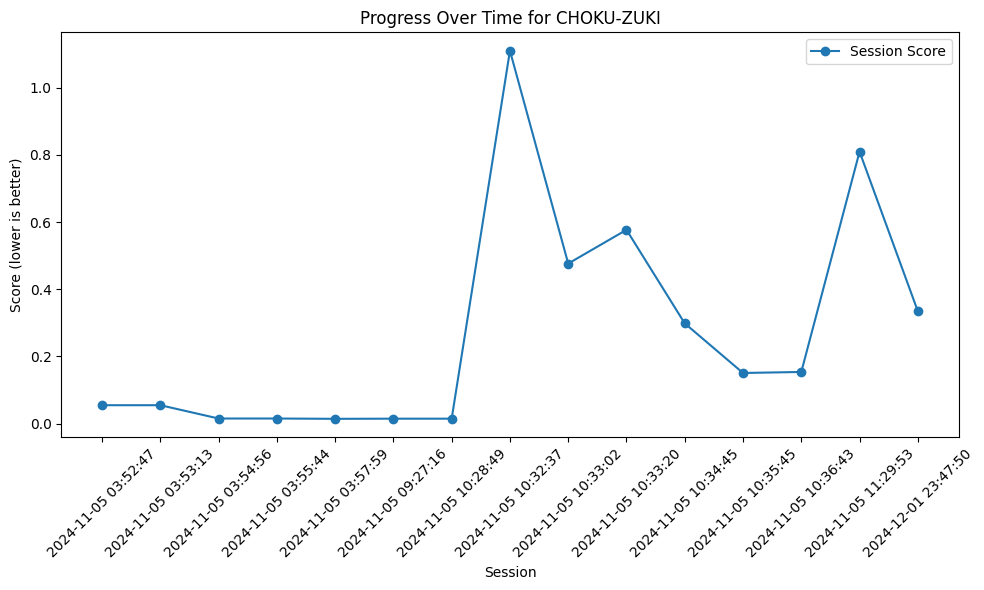

In [2]:
import cv2
import numpy as np
from scipy.spatial.distance import euclidean
import mediapipe as mp
import time
import json
import matplotlib.pyplot as plt
from collections import deque
from datetime import datetime
import pygame

pygame.mixer.init()
def play_sound(alert_sound_path):
    pygame.mixer.music.load(alert_sound_path)
    pygame.mixer.music.play()

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

# Mapping of keypoints to body parts for feedback
body_parts = {
    11: "left shoulder", 12: "right shoulder",
    13: "left elbow", 14: "right elbow",
    15: "left wrist", 16: "right wrist",
    23: "left hip", 24: "right hip",
    25: "left knee", 26: "right knee",
    27: "left ankle", 28: "right ankle"
}

# Function to load the reference sequence for a movement
def load_reference_sequence(movement, reference_sequences_file="reference_sequences.json"):
    with open(reference_sequences_file, "r") as f:
        reference_sequences = json.load(f)
    return np.array(reference_sequences.get(movement, []))

# Moving average function to smooth deviations
def smooth_deviation(deviations, window_size=5):
    smoothed = []
    for i in range(len(deviations)):
        window = deviations[max(0, i - window_size + 1):i + 1]
        smoothed.append(np.mean(window))
    return smoothed

# Function to save session data
def save_session_data(movement, score, progress_history_file="progress_history.json"):
    try:
        with open(progress_history_file, "r") as f:
            progress_history = json.load(f)
    except FileNotFoundError:
        progress_history = {}
    
    session_id = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    if movement not in progress_history:
        progress_history[movement] = []
    progress_history[movement].append({"session_id": session_id, "score": score})

    with open(progress_history_file, "w") as f:
        json.dump(progress_history, f)

# Function to plot progress over sessions
def plot_progress(movement, progress_history_file="progress_history.json"):
    try:
        with open(progress_history_file, "r") as f:
            progress_history = json.load(f)
    except FileNotFoundError:
        print(f"No progress history found for '{movement}'.")
        return

    if movement not in progress_history or len(progress_history[movement]) == 0:
        print(f"No progress data for movement '{movement}'.")
        return

    sessions = progress_history[movement]
    session_dates = [session["session_id"] for session in sessions]
    scores = [session["score"] for session in sessions]

    plt.figure(figsize=(10, 6))
    plt.plot(session_dates, scores, marker='o', label='Session Score')
    plt.xlabel("Session")
    plt.ylabel("Score (lower is better)")
    plt.title(f"Progress Over Time for {movement}")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Real-time feedback function with video or live camera support
def provide_real_time_feedback(movement, 
                                video_path=None,  # Use None for live camera, or provide a path to a video file
                                reference_sequences_file="reference_sequences.json", 
                                progress_history_file="progress_history.json", 
                                deviation_threshold=0.05, 
                                moving_average_window=5, 
                                enable_audio_feedback=True, 
                                alert_sound_path="beep.mp3"):
    
    # Load the reference sequence for the specified movement
    reference_sequence = load_reference_sequence(movement, reference_sequences_file)
    if len(reference_sequence) == 0:
        print(f"No reference sequence found for movement '{movement}'.")
        return

    # Open the video source (camera or video file)
    cap = cv2.VideoCapture(0 if video_path is None else video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video source: {'camera' if video_path is None else video_path}")
        return

    frame_idx = 0
    deviation_history = {i: deque(maxlen=moving_average_window) for i in body_parts.keys()}
    session_deviation_scores = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert frame to RGB for MediaPipe processing
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        result = pose.process(image_rgb)
        feedback_messages = []

        # Check if pose landmarks are detected
        if result.pose_landmarks:
            user_keypoints = [(lm.x, lm.y) for lm in result.pose_landmarks.landmark]

            # Ensure the frame is within the reference sequence
            if frame_idx < len(reference_sequence):
                ref_keypoints = reference_sequence[frame_idx]
                deviations = []

                # Calculate deviations and smooth using moving average
                for idx, (user_kp, ref_kp) in enumerate(zip(user_keypoints, ref_keypoints)):
                    deviation = euclidean(user_kp, ref_kp)
                    if idx in body_parts:
                        deviation_history[idx].append(deviation)
                        smoothed_deviation = np.mean(deviation_history[idx])
                        deviations.append(smoothed_deviation)

                        # Check deviation threshold and provide feedback
                        if smoothed_deviation > deviation_threshold:
                            feedback_messages.append(f"Adjust {body_parts[idx]}")
                            cv2.circle(frame, (int(user_kp[0] * frame.shape[1]), int(user_kp[1] * frame.shape[0])), 5, (0, 0, 255), -1)
                            if enable_audio_feedback:
                                play_sound(alert_sound_path)  # Play alert sound for high deviation
                        else:
                            cv2.circle(frame, (int(user_kp[0] * frame.shape[1]), int(user_kp[1] * frame.shape[0])), 5, (0, 255, 0), -1)

                # Calculate the average deviation for this frame
                frame_deviation = np.mean(deviations)
                session_deviation_scores.append(frame_deviation)

            # Increment frame index
            frame_idx += 1
            if frame_idx >= len(reference_sequence):
                frame_idx = 0  # Loop the reference sequence if needed

        # Display feedback messages on frame
        y_offset = 30
        for message in feedback_messages:
            cv2.putText(frame, message, (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            y_offset += 20

        # Show the frame with real-time feedback
        cv2.imshow("Real-Time Feedback", frame)

        # Press 'q' to exit the loop
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Calculate average deviation score for the session
    session_score = np.mean(session_deviation_scores)
    save_session_data(movement, session_score, progress_history_file)
    print(f"Session score for '{movement}': {session_score}")

    cap.release()
    cv2.destroyAllWindows()

# Example usage
movement = "CHOKU-ZUKI"

# Use for video file
video_path = None
provide_real_time_feedback(movement, video_path=video_path, deviation_threshold=0.1, moving_average_window=5, enable_audio_feedback=True, alert_sound_path="beep.mp3")

# Plot progress
plot_progress(movement)